## Dependencies

In [1]:
import os
import shutil
import cv2
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2023-04-14 15:22:39.576183: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Preprocess & Split

In [2]:
keep_hmdb51 = ["clap", "climb", "drink", "jump", "pour", "ride_bike", "ride_horse", 
        "run", "shoot_bow", "smoke", "throw", "wave"]

TRAIN_TAG, TEST_TAG = 1, 2
train_files, test_files = [], []
train_labels, test_labels = [], []
split_pattern_name = f"*test_split1.txt"
split_pattern_path = os.path.join('HMDB51/test_train_splits', split_pattern_name)
annotation_paths = glob.glob(split_pattern_path)
for filepath in annotation_paths:
    class_name = '_'.join(filepath.split('/')[-1].split('_')[:-2])
    if class_name not in keep_hmdb51:
        continue  # skipping the classes that we won't use.
    with open(filepath) as fid:
        lines = fid.readlines()
    for line in lines:
        video_filename, tag_string = line.split()
        tag = int(tag_string)
        if tag == TRAIN_TAG:
            train_files.append(video_filename)
            train_labels.append(class_name)
        elif tag == TEST_TAG:
            test_files.append(video_filename)
            test_labels.append(class_name)

### Obtain 10 optical flow frames of each video

In [8]:
import cv2
import os
import random

# Optical flow parameters
lk_params = dict(winSize=(15,15),
                 maxLevel=4,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create list to hold optical flow frames
opt_flow_frames = []


# Loop over all categories/classes and extract random frame
for category in keep_hmdb51:
    # set the path to the directory containing the videos
    video_dir = f'HMDB51/video_data/{category}'

    # get a list of all .avi files in the directory
    video_files = [f for f in os.listdir(video_dir) if f.endswith('.avi')]
    print(len(video_files))
    # iterate over each video file
    for video_file in video_files:

        #Load video
        video_path = os.path.join(video_dir, video_file)
        capture = cv2.VideoCapture(video_path)
        
        # Convert first frame to grayscale
        _, frame1 = capture.read()
        prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)
        
        # Create mask
        hsv_mask = np.zeros_like(frame1)
        
        # Make image saturation to a maximum value
        hsv_mask[..., 1] = 255
        
        # Till you scan the video
        while True:

            # Capture another frame and convert to gray scale
            _, frame2 = capture.read()
            next = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

            # Optical flow is now calculated
            flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
            
            # Compute magnite and angle of 2D vector
            mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
            # Set image hue value according to the angle of optical flow
            hsv_mask[..., 0] = ang * 180 / np.pi / 2
            # Set value as per the normalized magnitude of optical flow
            hsv_mask[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
            # Convert to rgb
            rgb_representation = cv2.cvtColor(hsv_mask, cv2.COLOR_HSV2BGR)

            #cv2.imshow('frame2', rgb_representation)
            opt_flow_frames.append(rgb_representation)
            #kk = cv2.waitKey(20) & 0xff
            # Press 'e' to exit the video
            #if kk == ord('e'):
            #    break
            # Press 's' to save the video
            #elif kk == ord('s'):
            #    cv2.imwrite('Optical_image.png', frame2)
            #    cv2.imwrite('HSV_converted_image.png', rgb_representation)
            prvs = next

        capture.release()
        cv2.destroyAllWindows()


        
        
        

130


error: OpenCV(4.7.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [4]:
print(len(opt_flow_frames))

290


TypeError: Invalid shape (240, 320, 2) for image data

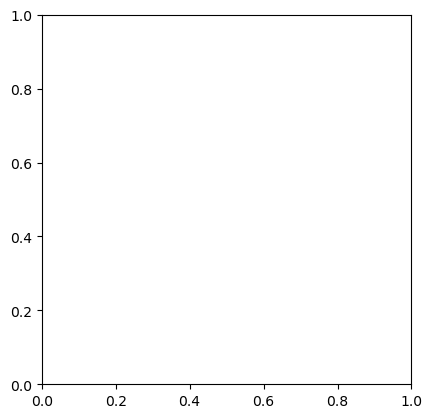

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load video
cap = cv2.VideoCapture('HMDB51/video_data/wave/winKen_wave_u_cm_np1_ba_bad_0.avi')

# Convert first frame to grayscale
_, frame1 = cap.read()
prvs = cv2.cvtColor(frame1,cv2.COLOR_BGR2GRAY)

#cv2.imshow('prvs', prvs)
  
# waits for user to press any key
# (this is necessary to avoid Python kernel form crashing)
#cv2.waitKey(0)

# closing all open windows
#cv2.destroyAllWindows()

# Optical flow parameters
lk_params = dict(winSize=(15,15),
                 maxLevel=4,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create list to hold optical flow frames
opt_flow_frames = []

# Loop through video frames
while True:
    # Read next frame
    ret, frame2 = cap.read()
    if not ret:
        break
    
    # Convert frame to grayscale
    next = cv2.cvtColor(frame2,cv2.COLOR_BGR2GRAY)
    
    # Compute optical flow
    flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    # Compute magnitude and angle of optical flow vectors
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    
    # Normalize magnitude to be between 0 and 255
    mag_norm = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    mag_norm = np.uint8(mag_norm)
    plt.imshow(flow)
    plt.axis('off')
    plt.show()
    
    # Append to list of optical flow frames
    opt_flow_frames.append(mag_norm)
    print(len(opt_flow_frames))
    
    # Set current frame as previous frame for next iteration
    prvs = next
    
    # If we have enough frames for a clip, stack them and reset list
    #if len(opt_flow_frames) == 16:
    #    clip = np.stack(opt_flow_frames, axis=-1)
    #    opt_flow_frames = []
        # Do something with clip here, such as feed it to a model for prediction


In [10]:
# Loop over all categories/classes and extract random frame
for category in keep_hmdb51:
    # set the path to the directory containing the videos
    video_dir = f'HMDB51/video_data/{category}'

    # get a list of all .avi files in the directory
    video_files = [f for f in os.listdir(video_dir) if f.endswith('.avi')]

print(video_files)

['likebeckam_wave_u_cm_np1_fr_med_6.avi', 'Crash_wave_u_cm_np1_ba_med_13.avi', 'Hitch_Part_1_wave_u_nm_np1_fr_goo_1.avi', 'TrumanShow_wave_u_nm_np1_fr_med_0.avi', 'Bubble_Gum_Club_2_wave_h_nm_np2_fr_med_0.avi', 'Oceans12_wave_h_nm_np1_fr_goo_8.avi', 'CastAway1_wave_u_cm_np1_ri_med_4.avi', 'RATRACE_wave_f_nm_np1_fr_med_21.avi', 'WeddingCrashers_wave_u_nm_np1_fr_goo_0.avi', 'UNREPEATABLE_wave_f_nm_np1_fr_med_5.avi', 'Song_I_Can_Wave_My_Hands_-_Cullen_s_Abc_s_wave_u_cm_np1_fr_med_2.avi', 'wave_and_say_hi_wave_u_nm_np1_fr_med_0.avi', 'Song_I_Can_Wave_My_Hands_-_Cullen_s_Abc_s_wave_u_cm_np1_fr_med_0.avi', 'Gaye_waves_to_the_paparazzi_as_she_flees_New_York_after_stalking_Adam_Lambert_in_Central_Park_wave_u_cm_np1_fr_med_0.avi', 'Bush_Wave_vs__Obama_Wave_and_Which_Commander-in-chief_Salutes_the_Best__You_Decide_wave_u_cm_np1_le_med_6.avi', 'Bush_Wave_vs__Obama_Wave_and_Which_Commander-in-chief_Salutes_the_Best__You_Decide_wave_u_cm_np1_fr_med_8.avi', 'BIG_FISH_wave_u_nm_np1_le_goo_28.avi', 'B

In [5]:
video_paths = []

for cls in keep_hmdb51:
    for video in os.listdir(f'HMDB51/video_data/{cls}'):
        if video.endswith('.avi'):
            video_paths.append(f'HMDB51/video_data/{cls}/{video}')

print(video_paths)

['HMDB51/video_data/clap/Finding_Forrester_3_clap_u_nm_np1_ri_med_0.avi', 'HMDB51/video_data/clap/LetThePeopleClap_clap_u_cm_np1_fr_med_3.avi', 'HMDB51/video_data/clap/#20_Rhythm_clap_u_nm_np1_le_goo_3.avi', 'HMDB51/video_data/clap/Faith_Rewarded_clap_u_cm_np1_ri_goo_1.avi', 'HMDB51/video_data/clap/LetThePeopleClap_clap_u_cm_np1_fr_med_2.avi', 'HMDB51/video_data/clap/Veoh_Alpha_Dog_1_clap_u_nm_np1_fr_goo_62.avi', 'HMDB51/video_data/clap/LetThePeopleClap_clap_u_cm_np1_fr_med_0.avi', 'HMDB51/video_data/clap/Aishwarya_Rai_Burns_David_Letterman_in_his_own_show_clap_u_cm_np1_fr_bad_1.avi', 'HMDB51/video_data/clap/LetThePeopleClap_clap_u_cm_np1_fr_med_1.avi', 'HMDB51/video_data/clap/Kurt_Kr_mer_-_Klatschen_im_Flugzeug_clap_u_cm_np1_fr_med_1.avi', 'HMDB51/video_data/clap/Song_I_Can_Wave_My_Hands_-_Cullen_s_Abc_s_clap_u_cm_np1_fr_med_3.avi', 'HMDB51/video_data/clap/NotAnotherTeenMovieslowclap_clap_u_cm_np1_fr_med_1.avi', 'HMDB51/video_data/clap/Hand_Clapping_Game__Bim_Bum__clap_f_nm_np2_fr_med

In [4]:
# Importing libraries
import cv2
import numpy as np
# Capturing the video file 0 for videocam else you can provide the url
#capture = cv2.VideoCapture("HMDB51/video_data/wave/winKen_wave_u_cm_np1_ba_bad_0.avi")

for path in video_paths:
    # Capturing the video file 0 for videocam else you can provide the url
    capture = cv2.VideoCapture(path)
    # Reading the first frame
    _, frame1 = capture.read()
    # Convert to gray scale
    prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
    # Create mask
    hsv_mask = np.zeros_like(frame1)
    # Make image saturation to a maximum value
    hsv_mask[..., 1] = 255

    # Create list to hold optical flow frames
    opt_flow_frames = []

    # Till you scan the video
    while(1):

        # Capture another frame and convert to gray scale
        _, frame2 = capture.read()
        next = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

        # Optical flow is now calculated
        flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        # Compute magnite and angle of 2D vector
        mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        # Set image hue value according to the angle of optical flow
        hsv_mask[..., 0] = ang * 180 / np.pi / 2
        # Set value as per the normalized magnitude of optical flow
        hsv_mask[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
        # Convert to rgb
        rgb_representation = cv2.cvtColor(hsv_mask, cv2.COLOR_HSV2BGR)

        cv2.imshow('frame2', rgb_representation)
        opt_flow_frames.append(rgb_representation)
        kk = cv2.waitKey(20) & 0xff
        # Press 'e' to exit the video
        if kk == ord('e'):
            break
        # Press 's' to save the video
        elif kk == ord('s'):
            cv2.imwrite('Optical_image.png', frame2)
            cv2.imwrite('HSV_converted_image.png', rgb_representation)
        prvs = next

    capture.release()
    cv2.destroyAllWindows()

error: OpenCV(4.7.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [8]:
print(len(opt_flow_frames))

320


In [9]:
for i in range(16,32):
    #cv2.imwrite(f'Optical_image_{i}.png', frame2)
    cv2.imwrite(f'flow_frames/HSV_converted_image_{i}.png', opt_flow_frames[i])
    